# Train APD model
Goal: Replicate Kai's results

In [1]:
## import file tools

In [2]:
import datetime
import sys
import os

## import general data science tools

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle

## import machine learning tools

In [4]:
import tensorflow as tf
# tf.enable_eager_execution()
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import clear_session
tf.compat.v1.disable_eager_execution()

2024-07-10 12:37:07.775264: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 12:37:07.775376: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 12:37:07.781082: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

## import Kai's custom functions

In [6]:
from apd.utils.trainingfuncs import *
from apd.utils.math_utils import *

# Load data

### Load data from starling stable_length

In [7]:
sys.path.append("..") # Adds higher directory to python modules path.
from apd.helpers.dataset_vars import *
from apd.helpers.SoundWav import *

In [8]:
dataset = Dataset('Starling')
analysis = 'stable_length'

In [9]:
species_folder = dataset.path_save
analysis_folder = os.path.join(species_folder, analysis)
log_folder = os.path.join(analysis_folder, 'log')

In [10]:
spec_file = sorted(glob(os.path.join(log_folder, 'all_specs_star.p')))[-1]

In [11]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [12]:
spec_df.tail()

,name,wav,spec
6995,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.8473503, -0.74000514, -0.6745358, -0.6307..."
6996,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.618756, -0.6190624, -0.6269182, -0.641789..."
6997,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.39242423, -0.3716945, -0.35015196, -0.346..."
6998,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.71081, -0.7151853, -0.5816425, -0.5211242..."
6999,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.63244075, -0.59842235, -0.56845856, -0.55..."


In [13]:
subjs = sorted(spec_df.name.value_counts().keys().tolist())

In [14]:
spec_h, spec_w = spec_df.spec[0].shape
print(spec_h, spec_w)

291 707


In [15]:
spec_list = spec_df.spec.values.tolist()

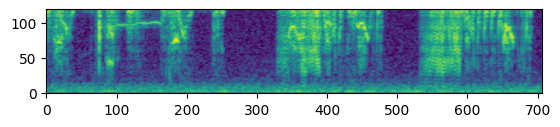

In [16]:
plt.imshow(spec_list[0][:120,:], origin='lower')

In [17]:
subj_list = spec_df.name.values.tolist()

In [18]:
n_slices = (4, 1)

In [19]:
len(spec_df) ## 500 exemplars for 14 subjects

7000

# Pretraining
### Spectrographic Jigsaw
Once you have your spectrograms, you want to slice them into the appropriate format for the spectrographic jigsaw. 

In [20]:
divided_w = spec_w//3

In [37]:
divided_w

235

In [21]:
input_list = []
output_list = []

for spec in spec_list:
    for i in range(3):
        slice_list, index_list = slice_matrix(spec[:, divided_w*i:divided_w*(i+1)], 
                                              n_slices=n_slices, slice_shape=(55, 224))
        input_list.append(slice_list)
        output_list.append(index_list)

/tmp/ipykernel_2868648/2821822015.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  slice_list, index_list = slice_matrix(spec[:, divided_w*i:divided_w*(i+1)],


In [22]:
input_list = np.array(input_list)

In [23]:
input_list.shape ## 21000

(21000, 4, 55, 224, 3)

In [24]:
input_list[0]

array([[[[-0.76836526, -0.76836526, -0.76836526],
         [-0.82801026, -0.82801026, -0.82801026],
         [-0.789782  , -0.789782  , -0.789782  ],
         ...,
         [-0.73357916, -0.73357916, -0.73357916],
         [-0.70962536, -0.70962536, -0.70962536],
         [-0.70479596, -0.70479596, -0.70479596]],

        [[-0.7303287 , -0.7303287 , -0.7303287 ],
         [-0.7505501 , -0.7505501 , -0.7505501 ],
         [-0.8019177 , -0.8019177 , -0.8019177 ],
         ...,
         [-0.78207695, -0.78207695, -0.78207695],
         [-0.8078543 , -0.8078543 , -0.8078543 ],
         [-0.7872305 , -0.7872305 , -0.7872305 ]],

        [[-0.7000191 , -0.7000191 , -0.7000191 ],
         [-0.75044155, -0.75044155, -0.75044155],
         [-0.84564173, -0.84564173, -0.84564173],
         ...,
         [-0.7725792 , -0.7725792 , -0.7725792 ],
         [-0.77437866, -0.77437866, -0.77437866],
         [-0.7738285 , -0.7738285 , -0.7738285 ]],

        ...,

        [[-0.644836  , -0.644836  , -0

In [39]:
input_list = np.transpose(input_list, (1, 0, 2, 3, 4))

In [40]:
input_list.shape

(21000, 4, 55, 224, 3)

In [27]:
224 * 256 / 44100

1.3003174603174603

In [ ]:
librosa.get_duration(sr = 44100, S = )

In [38]:
235 * 256 / 44100

1.364172335600907

In [33]:
output_data = np.array(output_list)

In [35]:
output_data.shape

(21000, 4)

In [41]:
input_train, input_test, output_train, output_test = train_test_split(input_list, output_list, test_size = 0.1, 
                                                                      random_state=20)

In [44]:
input_train.shape

(18900, 4, 55, 224, 3)

In [45]:
input_test.shape

(2100, 4, 55, 224, 3)

In [49]:
len(output_train)

18900

In [50]:
len(output_test)

2100

In [54]:
spec_list[0].shape

(291, 707)

In [61]:
librosa.get_duration(S = spec_list[0], n_fft = 2048, hop_length = 256)

2.5969565119777283